## Perlin spontaneous

Copyright 2019 Sebastian Spreizer

The MIT License

In [1]:
%matplotlib notebook

import numpy as np
import nest
import pylab as pl

import lib.connectivity_map as cm
import lib.lcrn_network as lcrn
import lib.animation as animation
import lib.plot3d as pl3d
import lib.colormap as cmap

#### Perlin landscape for connectivity

<IPython.core.display.Javascript object>


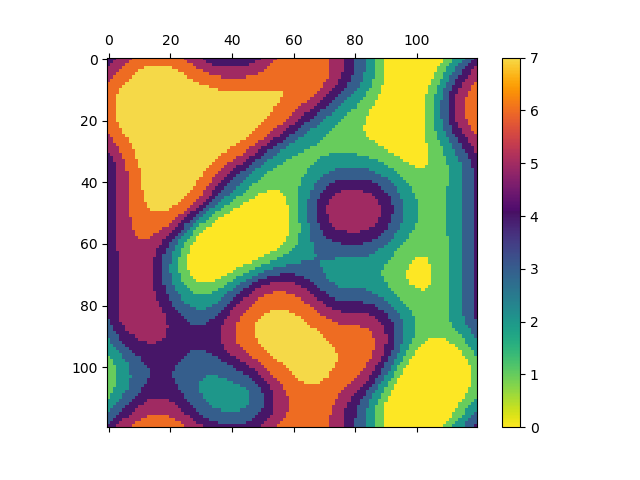

In [2]:
# Network size
nrowE = ncolE = 120
nrowI = ncolI = 60
npopE = nrowE * ncolE
npopI = nrowI * ncolI

nrow = nrowE
landscape = np.round(cm.Perlin_uniform(nrow, size=3, base=1) * 7).astype(int)
move = cm.move(nrow)

fig,ax = pl.subplots(1,1)
im = ax.matshow(landscape.reshape(nrow,-1), cmap=cmap.virno())
pl.colorbar(im, ax=ax)

#### Set Kernel Status

In [3]:
np.random.seed(0)
nest.ResetKernel()
nest.SetKernelStatus({
    'local_num_threads': 4,
    'resolution': 0.1,
})

#### Create nodes

In [4]:
params = {
    "C_m":      250.0,
    "E_L":      -70.0,
    "V_reset":  -70.0,
    "V_th":     -55.0,
    "t_ref":      2.0,
    "tau_m":     10.0,
    "tau_minus": 20.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 5.0,
}

popE = nest.Create('iaf_psc_alpha', npopE, params=params)
popI = nest.Create('iaf_psc_alpha', npopI, params=params)
pop = popE + popI

# Create devices
ngE = nest.Create('noise_generator')
ngI = nest.Create('noise_generator')
ng = ngE + ngI
sd = nest.Create('spike_detector', params={'start':500.})

#### Connect nodes

In [5]:
offsetE = popE[0]
offsetI = popI[0]

p = 0.05
stdE = 9
stdI = 12
g = 8
shift = 1


for idx in range(npopE):
    # E-> E
    source = idx, nrowE, ncolE, nrowE, ncolE, int(p * npopE), stdE, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    targets = (targets + shift * move[landscape[idx] % len(move)]) % npopE
    targets = targets[targets != idx] 
    nest.Connect([popE[idx]], (targets + offsetE).tolist(), syn_spec={'weight': 10.0})

    # E-> I
    source = idx, nrowE, ncolE, nrowI, ncolI, int(p * npopI), stdE / 2, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    nest.Connect([popE[idx]], (targets + offsetI).tolist(), syn_spec={'weight': 10.0})

for idx in range(npopI):
    # I-> E
    source = idx, nrowI, ncolI, nrowE, ncolE, int(p * npopE), stdI, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    nest.Connect([popI[idx]], (targets + offsetE).tolist(), syn_spec={'weight': g * -10.0})

    # I-> I
    source = idx, nrowI, ncolI, nrowI, ncolI, int(p * npopI), stdI / 2, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    targets = targets[targets != idx]
    nest.Connect([popI[idx]], (targets + offsetI).tolist(), syn_spec={'weight': g * -10.0})

# Connect noise input device to all neurons
nest.Connect(ngE, popE, syn_spec={'weight': 10.0})
nest.Connect(ngI, popI, syn_spec={'weight': 10.0})

nest.Connect(pop, sd)

#### Warming up

In [6]:
nest.SetStatus(ng, params={'std': 50.})
nest.Simulate(250.)
nest.SetStatus(ng, params={'mean': 35., 'std': 10.})
nest.Simulate(250.)

#### Start simulation

In [7]:
nest.SetStatus(ng, params={'mean': 35., 'std': 10.})
nest.Simulate(1000.)

#### Plot spiking activity

<IPython.core.display.Javascript object>


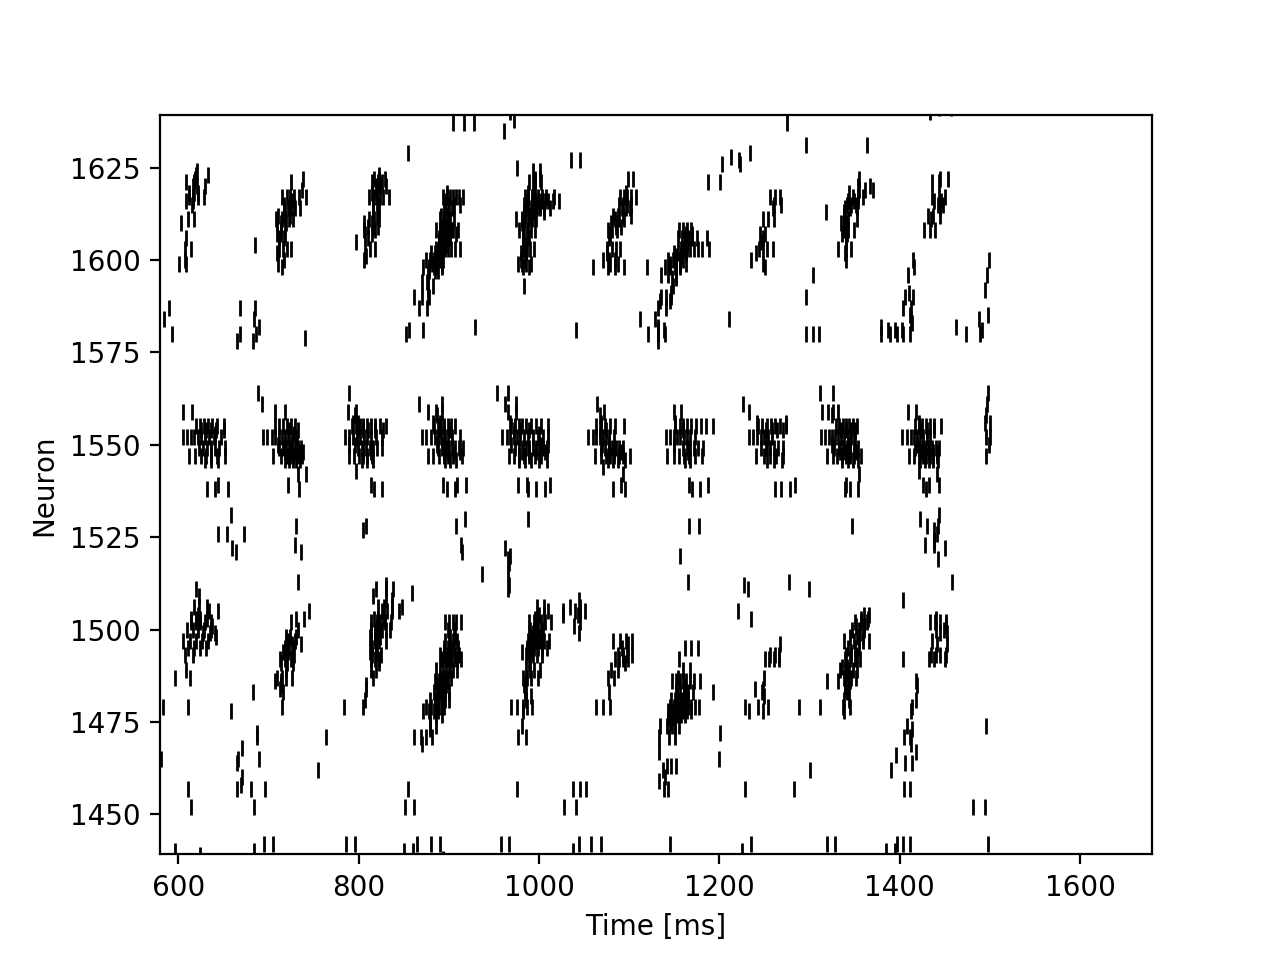

(200, 400)

In [13]:
%matplotlib notebook

sdE = nest.GetStatus(sd, 'events')[0]
ts, gids = sdE['times'], sdE['senders']
fig, ax = pl.subplots(1,1, dpi=200)
ax.plot(ts, gids, 'k|')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Neuron')
ax.set_ylim(200,400)

In [9]:
idx = gids - offsetE < npopE
gids, ts = gids[idx] - offsetE, ts[idx]
time = nest.GetKernelStatus('time')

ts_bins = np.arange(time-1000., time, 10.)
h = np.histogram2d(ts, gids, bins=[ts_bins, range(npopE + 1)])[0]
hh = h.reshape(-1, nrowE, ncolE)

<IPython.core.display.Javascript object>


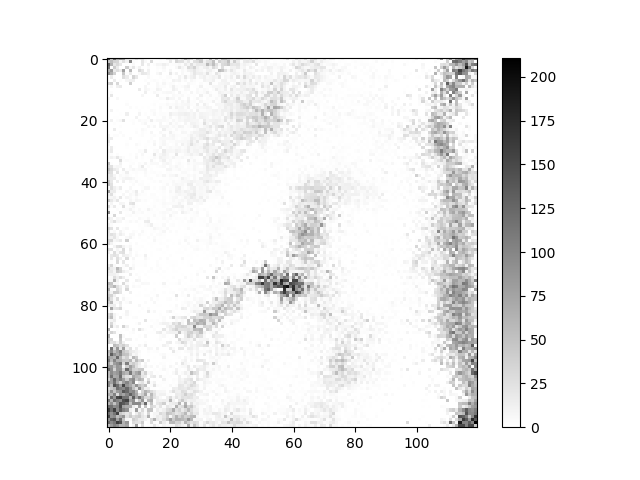

In [10]:
fig,ax = pl.subplots(1)
im = ax.imshow(hh.sum(0) / 1., cmap='binary')
pl.colorbar(im,ax=ax)

<IPython.core.display.Javascript object>


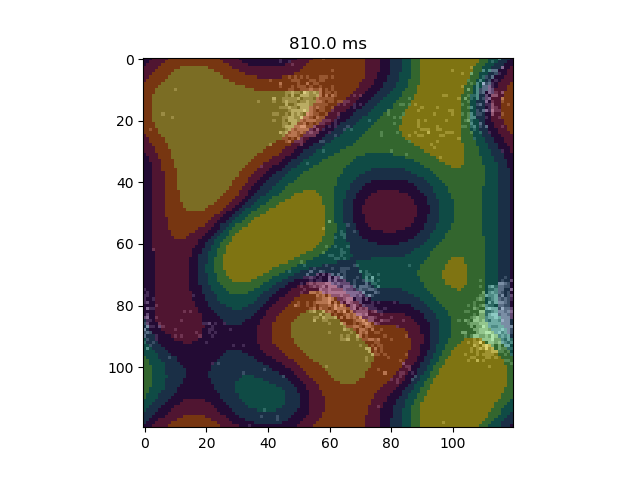

In [13]:
fig, ax = pl.subplots(1)
im2 = ax.imshow(landscape.reshape(nrow,-1), cmap=cmap.virno())
im1 = ax.imshow(hh[0], vmin=0, vmax=np.max(hh), cmap='binary_r', alpha=.5)

anim = animation.imshow(fig, ax, im1, hh, ts_bins)

In [ ]:
#anim.save('EI_networks-spontaneous.mp4', fps=10., extra_args=['-vcodec', 'libx264'])

In [15]:
animation.HTML(anim.to_jshtml())

In [ ]:
fig,ax = pl3d.scatter(ts,gids%nrow,gids//nrow)
ax.set_xlim(500,1500)